# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'bandgap'
folder = 'MP-bandgap'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset':            f'{target_folder}/dataset.pt',
    'train_dataset_std':  f'{target_folder}/train_dataset_std.pt',
    'val_dataset_std':    f'{target_folder}/val_dataset_std.pt',
    'test_dataset_std':   f'{target_folder}/test_dataset_std.pt',
    'r_dataset_std':      f'{target_folder}/ref_dataset_std.pt',
    'std_parameters':     f'{target_folder}/standardized_parameters.json',
    'dataset_parameters': f'{target_folder}/dataset_parameters.json',
    'uncertainty_data':   f'{target_folder}/uncertainty_data.json',
    'model':              f'{target_folder}/model.pt',
    'model_parameters':   f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_parameters'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset_std, val_dataset_std, test_dataset_std, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset']):
        # Generate data
        cld.generate_dataset('datasets/bandgap-MChX',
                             targets=['bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dataset_parameters'])

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset_std, standardized_parameters = cld.standardize_dataset(train_dataset)
    del train_dataset

    # Standardize test and validation datasets with train parameters
    val_dataset_std  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset_std = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)
    del val_dataset, test_dataset

    # Save datasets
    cld.save_datasets(train_dataset_std, val_dataset_std, test_dataset_std, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_parameters'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean    = standardized_parameters['target_mean']

Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset_std, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset_std,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset_std,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset_std[0].num_node_features

# Generate Graph Neural Network model

In [7]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model'])

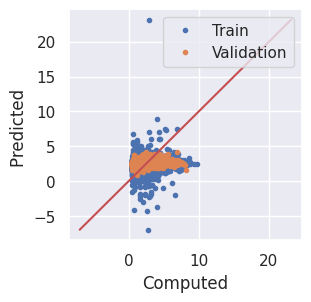

Epoch: 1, Train MAE: 1.4123, Val MAE: 1.3609
Epoch: 2, Train MAE: 1.3755, Val MAE: 1.3365
Epoch: 3, Train MAE: 1.3592, Val MAE: 1.3235
Epoch: 4, Train MAE: 1.3473, Val MAE: 1.3089
Epoch: 5, Train MAE: 1.3366, Val MAE: 1.3022
Epoch: 6, Train MAE: 1.3223, Val MAE: 1.2886
Epoch: 7, Train MAE: 1.3128, Val MAE: 1.2807
Epoch: 8, Train MAE: 1.2998, Val MAE: 1.2742
Epoch: 9, Train MAE: 1.2926, Val MAE: 1.2703
Epoch: 10, Train MAE: 1.2842, Val MAE: 1.2567


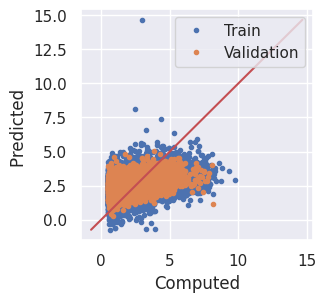

Epoch: 11, Train MAE: 1.2776, Val MAE: 1.2521
Epoch: 12, Train MAE: 1.2722, Val MAE: 1.2376
Epoch: 13, Train MAE: 1.2644, Val MAE: 1.2427
Epoch: 14, Train MAE: 1.2585, Val MAE: 1.2378
Epoch: 15, Train MAE: 1.2538, Val MAE: 1.2296
Epoch: 16, Train MAE: 1.2482, Val MAE: 1.2273
Epoch: 17, Train MAE: 1.2455, Val MAE: 1.2257
Epoch: 18, Train MAE: 1.2403, Val MAE: 1.2218
Epoch: 19, Train MAE: 1.2374, Val MAE: 1.2118
Epoch: 20, Train MAE: 1.2322, Val MAE: 1.2096


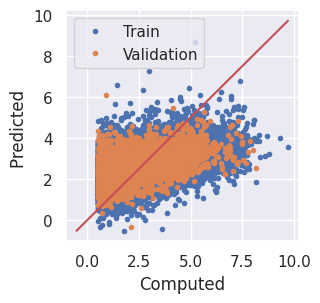

Epoch: 21, Train MAE: 1.2290, Val MAE: 1.2209
Epoch: 22, Train MAE: 1.2250, Val MAE: 1.2037
Epoch: 23, Train MAE: 1.2229, Val MAE: 1.1979
Epoch: 24, Train MAE: 1.2151, Val MAE: 1.1940
Epoch: 25, Train MAE: 1.2147, Val MAE: 1.2266
Epoch: 26, Train MAE: 1.2174, Val MAE: 1.1877
Epoch: 27, Train MAE: 1.2218, Val MAE: 1.2067
Epoch: 28, Train MAE: 1.2152, Val MAE: 1.1917
Epoch: 29, Train MAE: 1.2049, Val MAE: 1.1878
Epoch: 30, Train MAE: 1.2013, Val MAE: 1.1840


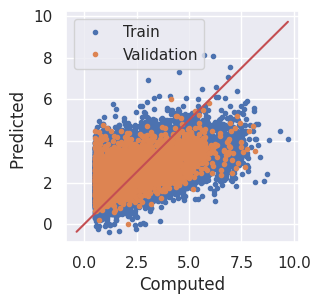

Epoch: 31, Train MAE: 1.1941, Val MAE: 1.1769
Epoch: 32, Train MAE: 1.1939, Val MAE: 1.1819
Epoch: 33, Train MAE: 1.1907, Val MAE: 1.1797
Epoch: 34, Train MAE: 1.1911, Val MAE: 1.1738
Epoch: 35, Train MAE: 1.1825, Val MAE: 1.1702
Epoch: 36, Train MAE: 1.1851, Val MAE: 1.1678
Epoch: 37, Train MAE: 1.1786, Val MAE: 1.1741
Epoch: 38, Train MAE: 1.1899, Val MAE: 1.1790
Epoch: 39, Train MAE: 1.1784, Val MAE: 1.1608
Epoch: 40, Train MAE: 1.1731, Val MAE: 1.1537


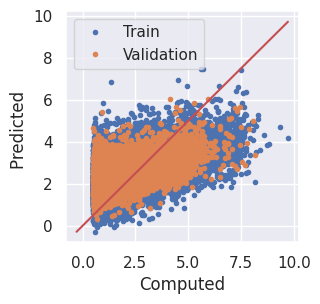

Epoch: 41, Train MAE: 1.1673, Val MAE: 1.1558
Epoch: 42, Train MAE: 1.1656, Val MAE: 1.1590
Epoch: 43, Train MAE: 1.1619, Val MAE: 1.1534
Epoch: 44, Train MAE: 1.1600, Val MAE: 1.1617
Epoch: 45, Train MAE: 1.1581, Val MAE: 1.1529
Epoch: 46, Train MAE: 1.1573, Val MAE: 1.1400
Epoch: 47, Train MAE: 1.1545, Val MAE: 1.1408
Epoch: 48, Train MAE: 1.1519, Val MAE: 1.1442
Epoch: 49, Train MAE: 1.1484, Val MAE: 1.1315
Epoch: 50, Train MAE: 1.1487, Val MAE: 1.1411


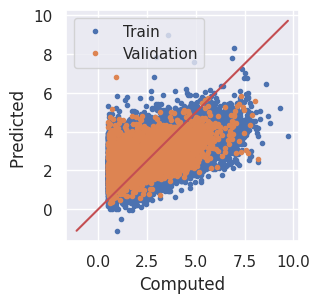

Epoch: 51, Train MAE: 1.1418, Val MAE: 1.1389
Epoch: 52, Train MAE: 1.1509, Val MAE: 1.1517
Epoch: 53, Train MAE: 1.1399, Val MAE: 1.1269
Epoch: 54, Train MAE: 1.1344, Val MAE: 1.1321
Epoch: 55, Train MAE: 1.1341, Val MAE: 1.1302
Epoch: 56, Train MAE: 1.1307, Val MAE: 1.1258
Epoch: 57, Train MAE: 1.1499, Val MAE: 1.1390
Epoch: 58, Train MAE: 1.1373, Val MAE: 1.1285
Epoch: 59, Train MAE: 1.1278, Val MAE: 1.1151
Epoch: 60, Train MAE: 1.1221, Val MAE: 1.1196


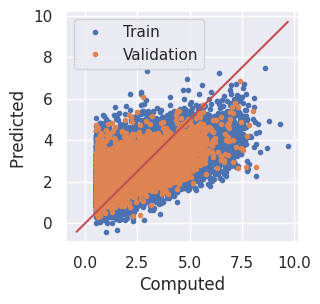

Epoch: 61, Train MAE: 1.1191, Val MAE: 1.1133
Epoch: 62, Train MAE: 1.1177, Val MAE: 1.1222
Epoch: 63, Train MAE: 1.1174, Val MAE: 1.1201
Epoch: 64, Train MAE: 1.1123, Val MAE: 1.1025
Epoch: 65, Train MAE: 1.1089, Val MAE: 1.1153
Epoch: 66, Train MAE: 1.1100, Val MAE: 1.1039
Epoch: 67, Train MAE: 1.1544, Val MAE: 1.1397
Epoch: 68, Train MAE: 1.1358, Val MAE: 1.1043
Epoch: 69, Train MAE: 1.1137, Val MAE: 1.0983
Epoch: 70, Train MAE: 1.1099, Val MAE: 1.0951


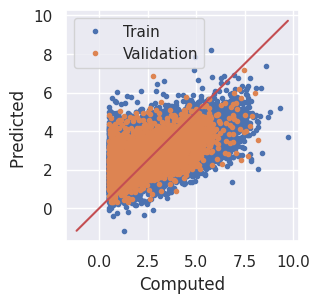

Epoch: 71, Train MAE: 1.1062, Val MAE: 1.0971
Epoch: 72, Train MAE: 1.1013, Val MAE: 1.0853
Epoch: 73, Train MAE: 1.0981, Val MAE: 1.0857
Epoch: 74, Train MAE: 1.1015, Val MAE: 1.0942
Epoch: 75, Train MAE: 1.0947, Val MAE: 1.0796
Epoch: 76, Train MAE: 1.0902, Val MAE: 1.0837
Epoch: 77, Train MAE: 1.0910, Val MAE: 1.0861
Epoch: 78, Train MAE: 1.0907, Val MAE: 1.0799
Epoch: 79, Train MAE: 1.0884, Val MAE: 1.0663
Epoch: 80, Train MAE: 1.0846, Val MAE: 1.0710


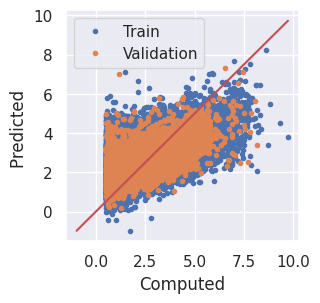

Epoch: 81, Train MAE: 1.0833, Val MAE: 1.0842
Epoch: 82, Train MAE: 1.0842, Val MAE: 1.0743
Epoch: 83, Train MAE: 1.0808, Val MAE: 1.0709
Epoch: 84, Train MAE: 1.0786, Val MAE: 1.0699
Epoch: 85, Train MAE: 1.0758, Val MAE: 1.0667
Epoch: 86, Train MAE: 1.0785, Val MAE: 1.0698
Epoch: 87, Train MAE: 1.0722, Val MAE: 1.0665
Epoch: 88, Train MAE: 1.0790, Val MAE: 1.0611
Epoch: 89, Train MAE: 1.0747, Val MAE: 1.0609
Epoch: 90, Train MAE: 1.0708, Val MAE: 1.0612


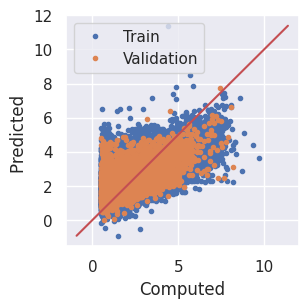

Epoch: 91, Train MAE: 1.0713, Val MAE: 1.0528
Epoch: 92, Train MAE: 1.0674, Val MAE: 1.0567
Epoch: 93, Train MAE: 1.0687, Val MAE: 1.0504
Epoch: 94, Train MAE: 1.0647, Val MAE: 1.0483
Epoch: 95, Train MAE: 1.0691, Val MAE: 1.0499
Epoch: 96, Train MAE: 1.0613, Val MAE: 1.0513
Epoch: 97, Train MAE: 1.0581, Val MAE: 1.0479
Epoch: 98, Train MAE: 1.0619, Val MAE: 1.0521
Epoch: 99, Train MAE: 1.0615, Val MAE: 1.0610
Epoch: 100, Train MAE: 1.0626, Val MAE: 1.0485


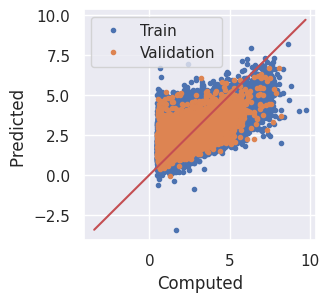

Epoch: 101, Train MAE: 1.0582, Val MAE: 1.0462
Epoch: 102, Train MAE: 1.0556, Val MAE: 1.0463
Epoch: 103, Train MAE: 1.0576, Val MAE: 1.0442
Epoch: 104, Train MAE: 1.0550, Val MAE: 1.0434
Epoch: 105, Train MAE: 1.0540, Val MAE: 1.0379
Epoch: 106, Train MAE: 1.0520, Val MAE: 1.0433
Epoch: 107, Train MAE: 1.0522, Val MAE: 1.0402
Epoch: 108, Train MAE: 1.0494, Val MAE: 1.0457
Epoch: 109, Train MAE: 1.0476, Val MAE: 1.0479
Epoch: 110, Train MAE: 1.0494, Val MAE: 1.0354


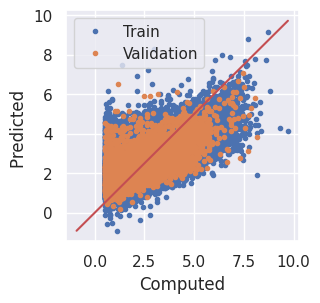

Epoch: 111, Train MAE: 1.0471, Val MAE: 1.0391
Epoch: 112, Train MAE: 1.0514, Val MAE: 1.0279
Epoch: 113, Train MAE: 1.0433, Val MAE: 1.0398
Epoch: 114, Train MAE: 1.0401, Val MAE: 1.0416
Epoch: 115, Train MAE: 1.0381, Val MAE: 1.0263
Epoch: 116, Train MAE: 1.0382, Val MAE: 1.0389
Epoch: 117, Train MAE: 1.0398, Val MAE: 1.0308
Epoch: 118, Train MAE: 1.0390, Val MAE: 1.0378
Epoch: 119, Train MAE: 1.0385, Val MAE: 1.0364
Epoch: 120, Train MAE: 1.0403, Val MAE: 1.0234


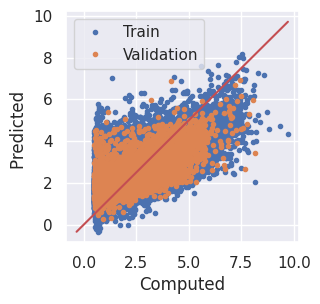

Epoch: 121, Train MAE: 1.0402, Val MAE: 1.0334
Epoch: 122, Train MAE: 1.0391, Val MAE: 1.0374
Epoch: 123, Train MAE: 1.0371, Val MAE: 1.0215
Epoch: 124, Train MAE: 1.0345, Val MAE: 1.0209
Epoch: 125, Train MAE: 1.0356, Val MAE: 1.0270
Epoch: 126, Train MAE: 1.0328, Val MAE: 1.0233
Epoch: 127, Train MAE: 1.0313, Val MAE: 1.0278
Epoch: 128, Train MAE: 1.0292, Val MAE: 1.0247
Epoch: 129, Train MAE: 1.0320, Val MAE: 1.0177
Epoch: 130, Train MAE: 1.0257, Val MAE: 1.0267


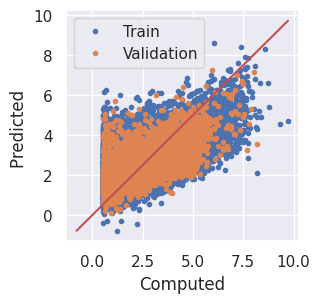

Epoch: 131, Train MAE: 1.0286, Val MAE: 1.0294
Epoch: 132, Train MAE: 1.0313, Val MAE: 1.0339
Epoch: 133, Train MAE: 1.0367, Val MAE: 1.0264
Epoch: 134, Train MAE: 1.0458, Val MAE: 1.0358
Epoch: 135, Train MAE: 1.0327, Val MAE: 1.0229
Epoch: 136, Train MAE: 1.0261, Val MAE: 1.0218
Epoch: 137, Train MAE: 1.0230, Val MAE: 1.0177
Epoch: 138, Train MAE: 1.0235, Val MAE: 1.0171
Epoch: 139, Train MAE: 1.0219, Val MAE: 1.0143
Epoch: 140, Train MAE: 1.0201, Val MAE: 1.0150


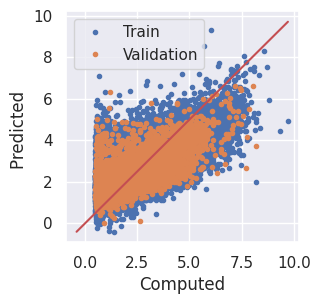

Epoch: 141, Train MAE: 1.0239, Val MAE: 1.0176
Epoch: 142, Train MAE: 1.0231, Val MAE: 1.0165
Epoch: 143, Train MAE: 1.0239, Val MAE: 1.0188
Epoch: 144, Train MAE: 1.0147, Val MAE: 1.0112
Epoch: 145, Train MAE: 1.0206, Val MAE: 1.0113
Epoch: 146, Train MAE: 1.0240, Val MAE: 1.0220
Epoch: 147, Train MAE: 1.0217, Val MAE: 1.0155
Epoch: 148, Train MAE: 1.0284, Val MAE: 1.0168
Epoch: 149, Train MAE: 1.0148, Val MAE: 1.0090
Epoch: 150, Train MAE: 1.0121, Val MAE: 1.0167


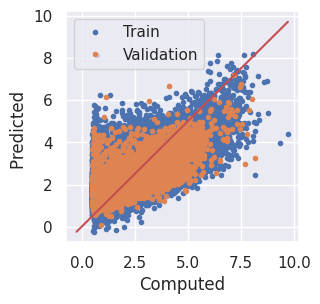

Epoch: 151, Train MAE: 1.0126, Val MAE: 1.0132
Epoch: 152, Train MAE: 1.0166, Val MAE: 1.0244
Epoch: 153, Train MAE: 1.0146, Val MAE: 1.0024
Epoch: 154, Train MAE: 1.0128, Val MAE: 1.0078
Epoch: 155, Train MAE: 1.0104, Val MAE: 1.0101
Epoch: 156, Train MAE: 1.0103, Val MAE: 1.0132
Epoch: 157, Train MAE: 1.0127, Val MAE: 1.0160
Epoch: 158, Train MAE: 1.0110, Val MAE: 1.0115
Epoch: 159, Train MAE: 1.0087, Val MAE: 1.0086
Epoch: 160, Train MAE: 1.0142, Val MAE: 1.0216


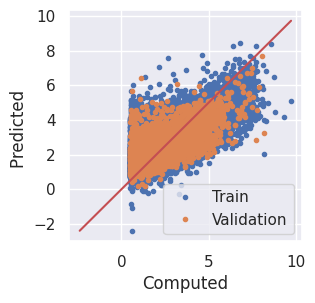

Epoch: 161, Train MAE: 1.0122, Val MAE: 1.0159
Epoch: 162, Train MAE: 1.0159, Val MAE: 1.0187
Epoch: 163, Train MAE: 1.0072, Val MAE: 1.0153
Epoch: 164, Train MAE: 1.0082, Val MAE: 1.0135
Epoch: 165, Train MAE: 1.0023, Val MAE: 1.0000
Epoch: 166, Train MAE: 1.0075, Val MAE: 1.0011
Epoch: 167, Train MAE: 1.0065, Val MAE: 1.0096
Epoch: 168, Train MAE: 1.0062, Val MAE: 1.0022
Epoch: 169, Train MAE: 1.0035, Val MAE: 1.0094
Epoch: 170, Train MAE: 1.0054, Val MAE: 1.0016


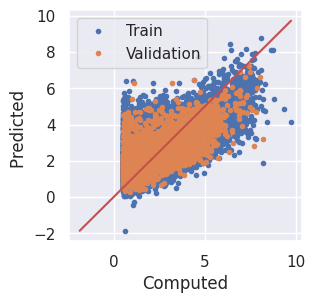

Epoch: 171, Train MAE: 1.0028, Val MAE: 1.0054
Epoch: 172, Train MAE: 1.0024, Val MAE: 1.0018
Epoch: 173, Train MAE: 1.0017, Val MAE: 1.0133
Epoch: 174, Train MAE: 1.0051, Val MAE: 1.0210
Epoch: 175, Train MAE: 1.0067, Val MAE: 0.9929
Epoch: 176, Train MAE: 1.0030, Val MAE: 1.0003
Epoch: 177, Train MAE: 1.0000, Val MAE: 0.9990
Epoch: 178, Train MAE: 1.0016, Val MAE: 1.0151
Epoch: 179, Train MAE: 1.0024, Val MAE: 1.0070
Epoch: 180, Train MAE: 0.9953, Val MAE: 1.0020


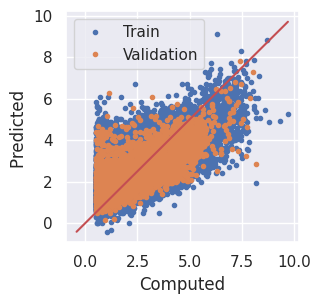

Epoch: 181, Train MAE: 0.9978, Val MAE: 0.9972
Epoch: 182, Train MAE: 0.9976, Val MAE: 1.0024
Epoch: 183, Train MAE: 0.9986, Val MAE: 0.9960
Epoch: 184, Train MAE: 0.9962, Val MAE: 0.9980
Epoch: 185, Train MAE: 1.0010, Val MAE: 0.9997
Epoch: 186, Train MAE: 0.9927, Val MAE: 1.0161
Epoch: 187, Train MAE: 0.9983, Val MAE: 0.9965
Epoch: 188, Train MAE: 0.9950, Val MAE: 0.9960
Epoch: 189, Train MAE: 0.9948, Val MAE: 0.9997
Epoch: 190, Train MAE: 0.9977, Val MAE: 1.0002


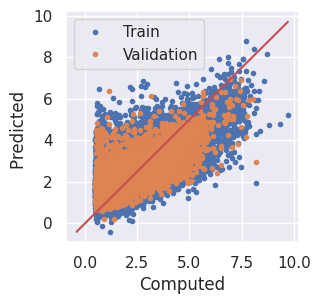

Epoch: 191, Train MAE: 0.9907, Val MAE: 0.9921
Epoch: 192, Train MAE: 0.9886, Val MAE: 0.9939
Epoch: 193, Train MAE: 0.9919, Val MAE: 0.9991
Epoch: 194, Train MAE: 0.9909, Val MAE: 0.9907
Epoch: 195, Train MAE: 0.9909, Val MAE: 0.9955
Epoch: 196, Train MAE: 0.9940, Val MAE: 0.9957
Epoch: 197, Train MAE: 0.9943, Val MAE: 0.9989
Epoch: 198, Train MAE: 0.9873, Val MAE: 1.0015
Epoch: 199, Train MAE: 0.9930, Val MAE: 0.9962
Epoch: 200, Train MAE: 0.9897, Val MAE: 0.9952


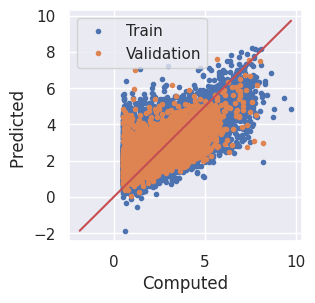

Epoch: 201, Train MAE: 0.9934, Val MAE: 1.0093
Epoch: 202, Train MAE: 0.9963, Val MAE: 0.9954
Epoch: 203, Train MAE: 0.9908, Val MAE: 0.9997
Epoch: 204, Train MAE: 0.9963, Val MAE: 0.9926
Epoch: 205, Train MAE: 0.9889, Val MAE: 0.9922
Epoch: 206, Train MAE: 0.9902, Val MAE: 0.9936
Epoch: 207, Train MAE: 0.9856, Val MAE: 0.9916
Epoch: 208, Train MAE: 0.9858, Val MAE: 0.9992
Epoch: 209, Train MAE: 0.9883, Val MAE: 0.9916
Epoch: 210, Train MAE: 0.9878, Val MAE: 0.9991


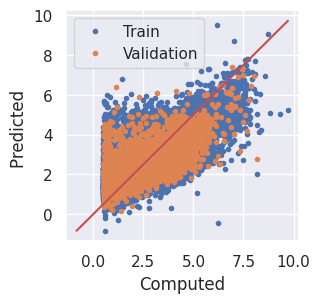

Epoch: 211, Train MAE: 0.9893, Val MAE: 0.9888
Epoch: 212, Train MAE: 0.9861, Val MAE: 0.9849
Epoch: 213, Train MAE: 0.9885, Val MAE: 0.9839
Epoch: 214, Train MAE: 0.9828, Val MAE: 0.9859
Epoch: 215, Train MAE: 0.9854, Val MAE: 0.9930
Epoch: 216, Train MAE: 0.9871, Val MAE: 0.9899
Epoch: 217, Train MAE: 0.9878, Val MAE: 0.9858
Epoch: 218, Train MAE: 0.9859, Val MAE: 0.9865
Epoch: 219, Train MAE: 0.9794, Val MAE: 0.9825
Epoch: 220, Train MAE: 0.9823, Val MAE: 0.9860


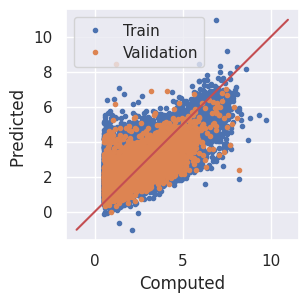

Epoch: 221, Train MAE: 0.9825, Val MAE: 0.9972
Epoch: 222, Train MAE: 0.9795, Val MAE: 0.9834
Epoch: 223, Train MAE: 0.9852, Val MAE: 0.9975
Epoch: 224, Train MAE: 0.9863, Val MAE: 0.9879
Epoch: 225, Train MAE: 0.9797, Val MAE: 0.9839
Epoch: 226, Train MAE: 0.9872, Val MAE: 0.9878
Epoch: 227, Train MAE: 0.9818, Val MAE: 0.9832
Epoch: 228, Train MAE: 0.9822, Val MAE: 0.9807
Epoch: 229, Train MAE: 0.9814, Val MAE: 0.9945
Epoch: 230, Train MAE: 0.9782, Val MAE: 0.9821


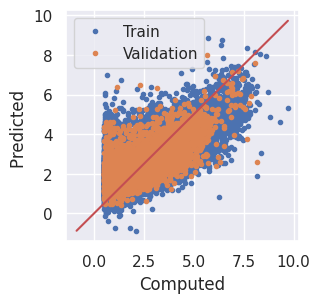

Epoch: 231, Train MAE: 0.9828, Val MAE: 0.9793
Epoch: 232, Train MAE: 0.9819, Val MAE: 0.9852
Epoch: 233, Train MAE: 0.9807, Val MAE: 0.9907
Epoch: 234, Train MAE: 0.9804, Val MAE: 0.9867
Epoch: 235, Train MAE: 0.9777, Val MAE: 0.9861
Epoch: 236, Train MAE: 0.9738, Val MAE: 0.9866
Epoch: 237, Train MAE: 0.9805, Val MAE: 0.9874
Epoch: 238, Train MAE: 0.9818, Val MAE: 0.9862
Epoch: 239, Train MAE: 0.9817, Val MAE: 0.9823
Epoch: 240, Train MAE: 0.9772, Val MAE: 0.9856


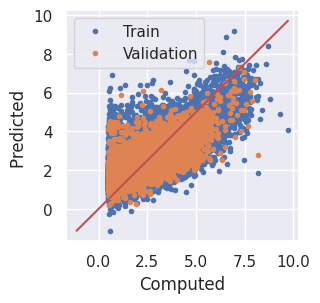

Epoch: 241, Train MAE: 0.9754, Val MAE: 0.9756
Epoch: 242, Train MAE: 0.9737, Val MAE: 0.9804
Epoch: 243, Train MAE: 0.9776, Val MAE: 0.9822
Epoch: 244, Train MAE: 0.9840, Val MAE: 0.9878
Epoch: 245, Train MAE: 0.9784, Val MAE: 0.9838
Epoch: 246, Train MAE: 0.9763, Val MAE: 0.9948
Epoch: 247, Train MAE: 0.9733, Val MAE: 0.9777
Epoch: 248, Train MAE: 0.9733, Val MAE: 0.9751
Epoch: 249, Train MAE: 0.9735, Val MAE: 0.9859
Epoch: 250, Train MAE: 0.9717, Val MAE: 0.9819


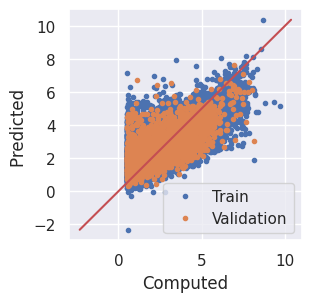

Epoch: 251, Train MAE: 0.9773, Val MAE: 0.9915
Epoch: 252, Train MAE: 0.9747, Val MAE: 0.9789
Epoch: 253, Train MAE: 0.9719, Val MAE: 0.9731
Epoch: 254, Train MAE: 0.9746, Val MAE: 0.9794
Epoch: 255, Train MAE: 0.9754, Val MAE: 0.9799
Epoch: 256, Train MAE: 0.9738, Val MAE: 0.9705
Epoch: 257, Train MAE: 0.9743, Val MAE: 0.9864
Epoch: 258, Train MAE: 0.9766, Val MAE: 0.9791
Epoch: 259, Train MAE: 0.9703, Val MAE: 0.9789
Epoch: 260, Train MAE: 0.9716, Val MAE: 0.9767


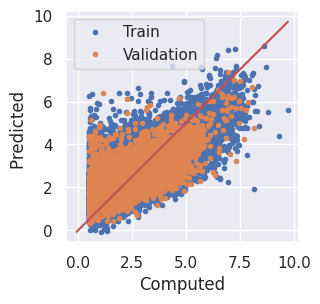

Epoch: 261, Train MAE: 0.9693, Val MAE: 0.9771
Epoch: 262, Train MAE: 0.9690, Val MAE: 0.9796
Epoch: 263, Train MAE: 1.0111, Val MAE: 1.0174
Epoch: 264, Train MAE: 0.9853, Val MAE: 0.9838
Epoch: 265, Train MAE: 0.9690, Val MAE: 0.9759
Epoch: 266, Train MAE: 0.9663, Val MAE: 0.9763
Epoch: 267, Train MAE: 0.9690, Val MAE: 0.9720
Epoch: 268, Train MAE: 0.9731, Val MAE: 0.9804
Epoch: 269, Train MAE: 0.9725, Val MAE: 0.9727
Epoch: 270, Train MAE: 0.9758, Val MAE: 0.9856


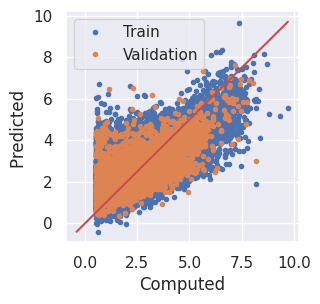

Epoch: 271, Train MAE: 0.9663, Val MAE: 0.9764
Epoch: 272, Train MAE: 0.9691, Val MAE: 0.9754
Epoch: 273, Train MAE: 0.9760, Val MAE: 0.9815
Epoch: 274, Train MAE: 0.9663, Val MAE: 0.9886
Epoch: 275, Train MAE: 0.9661, Val MAE: 0.9735
Epoch: 276, Train MAE: 0.9619, Val MAE: 0.9808
Epoch: 277, Train MAE: 0.9686, Val MAE: 0.9674
Epoch: 278, Train MAE: 0.9672, Val MAE: 0.9791
Epoch: 279, Train MAE: 0.9665, Val MAE: 0.9804
Epoch: 280, Train MAE: 0.9733, Val MAE: 0.9767


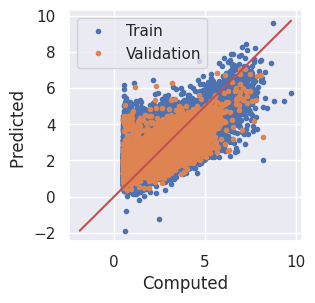

Epoch: 281, Train MAE: 0.9635, Val MAE: 0.9754
Epoch: 282, Train MAE: 0.9648, Val MAE: 0.9751
Epoch: 283, Train MAE: 0.9663, Val MAE: 0.9753
Epoch: 284, Train MAE: 0.9688, Val MAE: 0.9749
Epoch: 285, Train MAE: 0.9668, Val MAE: 0.9771
Epoch: 286, Train MAE: 0.9734, Val MAE: 0.9796
Epoch: 287, Train MAE: 0.9674, Val MAE: 0.9748
Epoch: 288, Train MAE: 0.9626, Val MAE: 0.9790
Epoch: 289, Train MAE: 0.9676, Val MAE: 0.9752
Epoch: 290, Train MAE: 0.9655, Val MAE: 0.9764


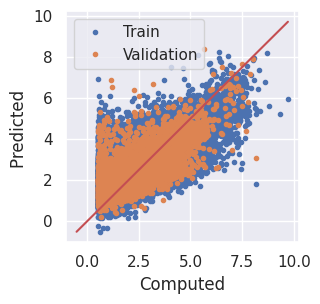

Epoch: 291, Train MAE: 0.9600, Val MAE: 0.9824
Epoch: 292, Train MAE: 0.9610, Val MAE: 0.9799
Epoch: 293, Train MAE: 0.9608, Val MAE: 0.9703
Epoch: 294, Train MAE: 0.9785, Val MAE: 0.9717
Epoch: 295, Train MAE: 0.9697, Val MAE: 0.9728
Epoch: 296, Train MAE: 0.9682, Val MAE: 0.9733
Epoch: 297, Train MAE: 0.9641, Val MAE: 0.9721
Epoch: 298, Train MAE: 0.9681, Val MAE: 0.9770
Epoch: 299, Train MAE: 0.9595, Val MAE: 0.9681
Epoch: 300, Train MAE: 0.9603, Val MAE: 0.9700


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

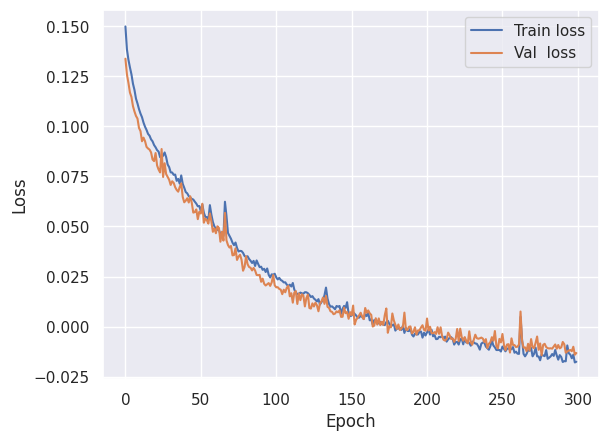

In [10]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [11]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

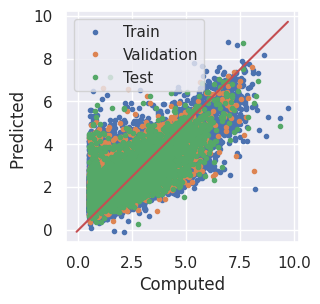

Train MAE: 0.9231, Val MAE: 0.9674, Test MAE: 0.9625


In [12]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   = clm.test(model, criterion, val_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  = clm.test(model, criterion, test_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [13]:
# Define reference dataset
# This is not necessarily just the full dataset, but it can include any
# additional validation not used as train, test or validation
dataset = [data for dataset in [train_dataset_std, val_dataset_std, test_dataset_std] for data in dataset]

# Save reference dataset
torch.save(dataset, files_names['r_dataset_std'])

# Generate data loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Standardize for better interpolation
uncert_mean  = uncertainties.mean()
uncert_std   = uncertainties.std()
uncert_scale = 1

uncertainties_std = (uncertainties - uncert_mean) * uncert_scale / uncert_std

# Check all labels are unique, otherwise you should rename them
labels = [data.label for data in dataset]
if len(labels) == len(set(labels)):
    print('All labels are unique')
else:
    print('Error: some labels are duplicated')

# Generate dictionary with uncertainty data
uncertainty_values = {}
for idx in range(len(dataset)):
    uncertainty_values.update(
        {dataset[idx].label: float(uncertainties_std[idx])}
    )
uncertainty_data = {
    'uncertainty_values': uncertainty_values,
    'uncert_mean':        uncert_mean,
    'uncert_std':         uncert_std,
    'uncert_scale':       uncert_scale
}

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncertainty_data'])

All labels are unique
